# Insurance for classification - Short Version (Without EDA and only with final model)

## Problem description

Your task is to apply various ML algorithms (see the rules below) to build a model explaining travel insurance claim outcomes based on the training sample and generate predictions for all observations from the test sample.

The dataset includes travel insurance policy records with the following columns:

- reward – Commission value earned on the insurance sale

- claim_status – Target variable (0 = Not Approved, 1 = Approved) Only in training sample

- person_gender – Gender identifier of the insured person

- entity_type – Type of selling entity

- channel – Distribution channel used

- support_interactions – Number of customer service interactions

- agent_id – Identifier for the selling agent

- customer_score – Computed value between 0-1 based on customer metrics

- entity_a – Identifier of the agency that sold the policy

- person_age – Age of the insured person

- location – Destination of the trip

- revenue – Net sales value of the policy (when <0 it covers discounts)

- product_id – Name of the insurance product

- trip_length – Duration of the insured trip in days

## File description

- insurance_train.csv – training data contains 56993 observations and 14 columns along with the target variable claim_status

- insurance_test.csv – test data contains 6333 observations and 13 columns without the target variable

## Requirements

### Exploratory Data Analysis:
- Analyze the dataset to identify key patterns, correlations, and potential challenges introduced by the additional variables.
- Visualize distributions and relationships among variables.
### Feature Engineering:
- Consider transformation or scaling of variables as needed. 
- Evaluate the impact of the supplementary variables on model performance.
### Modeling:
- Build, train, and compare multiple regression models. 
- Optimize model hyperparameters using cross-validation.
### Predictions:
- Generate predictions for all observations in the test dataset. 
- Document model performance and reasoning behind the selected approach.
### Documentation:
- Provide a clear explanation of your analysis, modeling choices, and any challenges faced while integrating the additional variables.
## Various algorithms
For each of the datasets please consider and compare at least 3 different ML algorithms discussed in the ML1 course (e.g. linear/logistic regression, KNN, LASSO, ridge, elastic net, SVM/SVR with various kernel functions). You can also apply in addition any other algorithms you know, but they cannot be used instead of the ones mentioned before.

## Selection of the best algorithm
The choice of the final algorithm applied to generate predictions should be clearly explained in the presentation.

HINT !!!!! Use the internal division of the training data into train/validation/test samples to make sure that you correcly assess the performance of your models on the new data.

## Performance measure
The performance of predictions will be based on:

RMSE for the appartments dataset
balanced accuracy for the insurance dataset
Please report the expected value of a particular performance measure (expectation for the test sample) in your presentation.

#### Dependencies loading

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from IPython.display import display, HTML

# Statistical modeling
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Scikit-learn components
from sklearn.base import clone
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    balanced_accuracy_score,
    classification_report,
    roc_auc_score,
    ConfusionMatrixDisplay
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (
    FunctionTransformer, 
    OneHotEncoder, 
    PowerTransformer, 
    StandardScaler
)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.utils import resample

# Category encoders and imbalance handling
from category_encoders import TargetEncoder
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTENC

# Settings
pd.set_option("display.max_columns", 500)
np.random.seed(2115)

#### Path setup

Creating paths for project files
```python

In [ ]:
raw_input_data_path = r"C:\Users\wojci\Desktop\Machine Learning\MachineLearning1\Insurances\data_input"

## FEATURE ENGINEERING

#### Grouping categorical variables

Purpose and Significance:

- Feature Engineering: The primary purpose of this code is to create new, potentially more informative features from existing data. Categorizing countries into regions and products into broader categories can help machine learning models generalize better and can also simplify exploratory data analysis.
- Data Standardization
- Handling Variability: The functions provide a structured way to manage a large number of unique country names or product IDs by grouping them.
- Interpretability: Using categories like 'europe' or 'TravelShield' can be more interpretable in analyses and model explanations than using individual country or product names.
- Context for Previous Analyses: This code explains how the region and product_category variables, which were analyzed in the previously provided images showing their distribution against claim status, were derived.

In [3]:
# Load data
df = pd.read_csv(f"{raw_input_data_path}/insurance_train.csv")

# Data transformations

def map_country_to_region(country):
    """
    Categorizes countries into geographic regions.
    
    Args:
        country (str): Country name to be categorized
        
    Returns:
        str: Region name (europe, asia, oceania, america, africa, other)
    """
    # Define country groupings by region
    europe = [
        'spain', 'croatia', 'finland', 'united kingdom', 'netherlands', 'switzerland',
        'france', 'denmark', 'russian federation', 'greece', 'romania', 'germany',
        'cyprus', 'ukraine', 'serbia', 'italy', 'portugal', 'belgium', 'sweden',
        'norway', 'austria', 'iceland', 'poland', 'czech republic', 'ireland',
        'republic of montenegro', 'slovenia', 'malta', 'lithuania', 'latvia',
        'macedonia, the former yugoslav republic of', 'albania', 'luxembourg',
        'estonia', 'hungary', 'bulgaria', 'belarus', 'bosnia and herzegovina'
    ]
    
    asia = [
        'thailand', 'viet nam', 'malaysia', 'indonesia', 'china',
        'taiwan, province of china', 'cambodia', 'india', 'philippines', 'myanmar',
        'united arab emirates', 'hong kong', 'japan', 'sri lanka', 'brunei darussalam',
        'korea, republic of', 'turkey', 'israel', 'bangladesh', 'macao', 'mongolia',
        "lao people's democratic republic", 'nepal', 'pakistan', 'qatar', 'maldives',
        'bahrain', 'saudi arabia', 'jordan', 'uzbekistan', 'kazakhstan', 'azerbaijan',
        'georgia', 'lebanon', 'kyrgyzstan', 'tunisia', 'tibet', 'iran, islamic republic of',
        'bhutan', 'tajikistan', 'armenia', 'turkmenistan', 'singapore'
    ]
    
    oceania = [
        'australia', 'new zealand', 'fiji', 'vanuatu', 'guam', 'solomon islands',
        'french polynesia', 'new caledonia', 'samoa', 'papua new guinea'
    ]
    
    america = [
        'united states', 'brazil', 'canada', 'peru', 'colombia', 'mexico',
        'puerto rico', 'argentina', 'costa rica', 'bolivia', 'venezuela', 'guadeloupe',
        'bermuda', 'panama', 'jamaica', 'trinidad and tobago', 'dominican republic',
        'ecuador', 'northern mariana islands', 'guatemala', 'cayman islands',
        'barbados', 'uruguay', 'chile', 'virgin islands, u.s.'
    ]
    
    africa = [
        'kenya', 'morocco', 'zambia', 'ghana', 'ethiopia', 'uganda', 'nigeria',
        'namibia', 'south africa', 'tanzania, united republic of', 'egypt',
        'cameroon', 'zimbabwe', 'senegal', 'mauritius', 'botswana', 'mali',
        'angola', 'sierra leone', 'guinea', 'guinea-bissau', 'rwanda'
    ]

    other = [
        'reunion', 'macedonia, the former yugoslav republic of', 'moldova, republic of'
    ]
    
    # Return the appropriate region
    country = country.lower()
    if country in europe:
        return 'europe'
    elif country in asia:
        return 'asia'
    elif country in oceania:
        return 'oceania'
    elif country in america:
        return 'america'
    elif country in africa:
        return 'africa'
    else:
        return 'other'

# Apply country-to-region mapping
df['region'] = df['location'].str.lower().map(map_country_to_region)

def map_product_to_category(product_name):
    """
    Categorizes insurance products into product families.
    
    Args:
        product_name (str): Product name to be categorized
        
    Returns:
        str: Product category name
    """
    # Define product groupings by category
    secure_plan = [
        'SecurePlan Flex',
        'SecurePlan OneWay',
        'SecurePlan Annual Lite',
        'SecurePlan Standard',
        'SecurePlan Individual',
        'SecurePlan Family',
        'SecurePlan Junior'
    ]
    
    travel_shield = [
        'TravelShield Basic',
        'TravelShield Core',
        'TravelShield Plus',
        'TravelShield Value',
        'TravelShield Premium',
        'TravelShield Elite',
        'TravelShield Annual Pro'
    ]
    
    trip_guard = [
        'TripGuard Cancel',
        'TripGuard TicketCover',
        'TripGuard Plus',
        'TripGuard Pro',
        'TripGuard Max',
        'TripGuard Annual Lite',
        'TripGuard Annual Pro',
        'TripGuard Annual Max'
    ]
    
    cruise_safe = [
        'CruiseSafe Trip',
        'CruiseSafe Family'
    ]
    
    other_products = [
        'DriveSafe Rental Addon',
        'QuickProtect 24'
    ]
    
    # Map product to its category
    if product_name in secure_plan:
        return 'SecurePlan'
    elif product_name in travel_shield:
        return 'TravelShield'
    elif product_name in trip_guard:
        return 'TripGuard'
    elif product_name in cruise_safe:
        return 'CruiseSafe'
    elif product_name in other_products:
        return 'Other'
    else:
        return 'Unknown'  # Handle any unexpected products

# Apply product categorization
df['product_category'] = df['product_id'].apply(map_product_to_category)

# Creating the binary categorical variable
df['reward_zero'] = df['reward'].apply(lambda x: 1 if x == 0 else 0).astype('category')

# Let's create a new column for the trip length 2 possibilities category - if trip_length is over 300
df['trip_length_category'] = df['trip_length'].apply(lambda x: 1 if x > 300 else 0).astype('category')



#### Dividing dataset into 3 parts

Significance in Machine Learning Workflow:

- Unbiased Evaluation: Separating data into these distinct sets (train, validation, test) is fundamental for building robust machine learning models. It allows for training the model on one portion of data, tuning it on another, and finally, evaluating its true generalization performance on completely unseen data.
- Preventing Data Leakage: By keeping the test set separate and untouched until the final evaluation, it prevents information from the test set inadvertently influencing the model training or selection process, which could lead to an overly optimistic performance estimate.
- Hyperparameter Tuning: The validation set plays a key role in selecting the best hyperparameters for a model without "contaminating" the test set.
- Importance of Stratification: For imbalanced datasets like the one indicated for claim_status, stratification is crucial. Without it, random splits could lead to validation or test sets that poorly represent the minority class, making model evaluation unreliable for that class.

In [4]:
# Prepare features and target variable
X = df.drop(columns=['claim_status'])  # All features except target
y = df['claim_status']  # Target variable

# Initial split: 70% training, 30% temporary holdout (stratified)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, 
    y, 
    test_size=0.30, 
    stratify=y,  # Maintain class distribution
    random_state=42  # Reproducibility
)

# Split temporary holdout into validation and test sets (50/50 of the 30%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, 
    y_temp, 
    test_size=0.50, 
    stratify=y_temp,  # Maintain class distribution
    random_state=42  # Reproducibility
)

# Print dataset sizes for verification
print(f"Dataset sizes:")
print(f"Train: {X_train.shape}")
print(f"Validation: {X_val.shape}")
print(f"Test: {X_test.shape}")

# Check for missing values in each dataset
print("\nMissing value counts:")
print(f"Training set: {X_train.isna().sum().sum()} missing values")
print(f"Validation set: {X_val.isna().sum().sum()} missing values")
print(f"Test set: {X_test.isna().sum().sum()} missing values")

Dataset sizes:
Train: (39895, 17)
Validation: (8549, 17)
Test: (8549, 17)

Missing value counts:
Training set: 0 missing values
Validation set: 0 missing values
Test set: 0 missing values


#### Feature processing pipeline configuration

##### Configuration for logistic regression

Version to be used for logistic regression, Random Forest and XGBoost. All those are able to handle categorical variables. Grouping them, in case of countries and products resulted in worse results of the models, so I decided to use them as they are. Rest of the transformations will remain the same. I decided to use log transformation for revenue, reward, trip_length, age and customer_score variables - featuring also the securement for 0 values. For all the categorical variables I decided to go with target encoding, as during the tests it was giving better results than one-hot encoding.

In [5]:
# Columns to apply log transformation
log_cols = ['reward', 'revenue', 'person_age', 'trip_length', 'customer_score']

# Columns for target encoding (high-cardinality categorical features)
target_cols = ['entity_type', 'person_gender', 'agent_id', 'product_id', 
              'location', 'support_interactions', 'entity_a', 'channel']

# Safe log transformation to handle negative values
def safe_log1p(x):
    """Apply log1p transformation with protection against negative values"""
    x = np.where(x < 0, 1e-10, x)  # Replace negatives with small positive value
    return np.log1p(x)

# Pipeline for log-transformed features
log_transformer = Pipeline(steps=[
    ('log', FunctionTransformer(safe_log1p, feature_names_out='one-to-one')),
    ('scaler', StandardScaler())  # Standardize features after log transform
])

# Pipeline for target-encoded categorical features
target_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Handle missing values
    ('target', TargetEncoder()),  # Encode high-cardinality categories
])

# Count transformed features
n_log = len(log_cols)  # Number of log-transformed features (5)
n_target = len(target_cols)  # Number of target-encoded features (7)

# Build the complete preprocessing pipeline
preprocessor = ColumnTransformer(transformers=[
    ('log', log_transformer, log_cols),
    ('target', target_transformer, target_cols),
])

# Fit preprocessor on training data
preprocessor.fit(X_train, y_train)

# Get indices of categorical features for SMOTE
# (Target encoding produces one column per input feature)
target_indices = list(range(n_log, n_log + n_target))
categorical_features_indices = target_indices

Model Training & Tuning Pipeline - The primary goal of this function is to automate the process of:

- Preprocessing Data: Applying predefined preprocessing steps.
- Addressing Class Imbalance: Using SMOTE (Synthetic Minority Over-sampling Technique) to oversample the minority class.
- Hyperparameter Tuning: Finding the best hyperparameters for a given model using GridSearchCV.
- Robust Evaluation: Evaluating the model's performance using balanced_accuracy_score on a separate validation set.

In [6]:
def train_and_tune_model(model, param_grid, X_train, y_train, X_val, y_val, model_name='Model'):
    """
    Trains and tunes a model using GridSearchCV with SMOTE for imbalanced data.
    
    Args:
        model: Base classifier model
        param_grid: Dictionary of hyperparameters to tune
        X_train: Training features
        y_train: Training labels
        X_val: Validation features
        y_val: Validation labels
        model_name: Name for model identification
        
    Returns:
        best_estimator: The best performing model from GridSearchCV
    """
    
    # Create pipeline with preprocessing, SMOTE, and classifier
    pipeline = ImbPipeline(steps=[
        ('preprocessing', preprocessor),  # Data preprocessing steps
        ('smote', SMOTENC(categorical_features=categorical_features_indices, random_state=42)),  # Handle class imbalance
        ('classifier', model)  # Classifier model
    ])

    # Configure GridSearchCV for hyperparameter tuning
    grid = GridSearchCV(
        pipeline,
        param_grid={'classifier__' + k: v for k, v in param_grid.items()},  # Add classifier prefix to params
        scoring='balanced_accuracy',  # Metric for evaluation
        error_score='raise',  # Raise exceptions for errors
        cv=3,  # 5-fold cross-validation
        n_jobs=-1,  # Use all available cores
        verbose=1  # Show progress
    )

    # Train model with hyperparameter tuning
    grid.fit(X_train, y_train)

    # Evaluate on validation set
    y_val_pred = grid.predict(X_val)
    val_score = balanced_accuracy_score(y_val, y_val_pred)

    # Print results
    print(f"{model_name} Results")
    print("Best parameters:", grid.best_params_)
    print("Validation balanced accuracy:", round(val_score, 4))
    print("="*50)  # Separator line

    return grid.best_estimator_

location variable analysis

- Claim Status = 0 (No Claim):
other is the most common (26.27%), followed by singapore (20.36%), malaysia (9.50%), thailand (9.39%), etc.
- Claim Status = 1 (Claim):
singapore is overwhelmingly dominant (60.67%), followed by other (12.95%), china (5.28%), etc.
- location is an extremely powerful predictor. 'Singapore' which is a significant location for non-claims, becomes overwhelmingly dominant for claims. This implies that claims are highly concentrated in specific locations, with Singapore being a major hotspot. This variable will be highly influential in the model.

## MODELING

#### Logistic Regression

- Pipeline for Robustness: Using a pipeline (managed by train_and_tune_model) ensures that preprocessing and resampling are applied consistently and correctly within cross-validation, preventing data leakage.
- Addressing Imbalance: Combines class_weight='balanced' in the model and SMOTENC in the pipeline, providing a two-pronged approach to tackle class imbalance.
- Hyperparameter Tuning: Uses GridSearchCV for systematic optimization of model parameters.
- Appropriate Evaluation Metrics: Employs balanced_accuracy_score, classification_report, and roc_auc_score, which are highly suitable for imbalanced classification problems, offering a more nuanced view than simple accuracy.
- Validation Set for Generalization: Strictly separates training and validation data to get an unbiased estimate of real-world performance.
- Overfitting Detection: Explicitly compares training and validation performance to diagnose potential overfitting.

In [7]:
# Initialize logistic regression model with balanced class weights
log_model = LogisticRegression(max_iter=5000, class_weight='balanced', random_state=42)

# Define hyperparameter grid for tuning
log_param_grid = {
    'C': [0.1]  # Regularization strength
}

# Train and tune the model using validation set
best_log = train_and_tune_model(log_model, log_param_grid, X_train, y_train, X_val, y_val, model_name='Logistic Regression')

# Evaluate model performance on validation set
# Generate classification metrics (precision, recall, f1-score)
y_val_pred = best_log.predict(X_val)
report = classification_report(y_val, y_val_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print("Classification Report (Validation Set):")
print(report_df[['precision', 'recall', 'f1-score', 'support']].round(4))

# Calculate and display AUC-ROC score
auc_score = roc_auc_score(y_val, best_log.predict_proba(X_val)[:, 1])
print(f"AUC Score (val): {round(auc_score, 4)}")

# Check for potential overfitting by comparing train vs validation performance
# Training set evaluation
y_train_pred = best_log.predict(X_train)
train_report = classification_report(y_train, y_train_pred, output_dict=True)
train_report_df = pd.DataFrame(train_report).transpose()
print("\nClassification Report (Train Set):")
print(train_report_df[['precision', 'recall', 'f1-score', 'support']].round(4))

# Training set AUC-ROC score
train_auc_score = roc_auc_score(y_train, best_log.predict_proba(X_train)[:, 1])
print(f"AUC Score (train): {round(train_auc_score, 4)}")

# Calculate balanced accuracy for training set
train_balanced_accuracy = balanced_accuracy_score(y_train, y_train_pred)
print(f"Balanced Accuracy Score (train): {round(train_balanced_accuracy, 4)}")

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Logistic Regression Results
Best parameters: {'classifier__C': 0.1}
Validation balanced accuracy: 0.7958
Classification Report (Validation Set):
              precision  recall  f1-score    support
0                0.9959  0.8156    0.8968  8424.0000
1                0.0588  0.7760    0.1093   125.0000
accuracy         0.8151  0.8151    0.8151     0.8151
macro avg        0.5274  0.7958    0.5031  8549.0000
weighted avg     0.9822  0.8151    0.8853  8549.0000
AUC Score (val): 0.8523

Classification Report (Train Set):
              precision  recall  f1-score     support
0                0.9943  0.8175    0.8973  39311.0000
1                0.0529  0.6866    0.0983    584.0000
accuracy         0.8156  0.8156    0.8156      0.8156
macro avg        0.5236  0.7521    0.4978  39895.0000
weighted avg     0.9806  0.8156    0.8856  39895.0000
AUC Score (train): 0.816
Balanced Accuracy Score (train): 0.7521


Strengths:

- The model achieves a good balanced_accuracy (0.7964) and AUC (0.8523) on the validation set, indicating a reasonable ability to correctly classify both majority and minority classes.
- The use of class_weight='balanced' and SMOTE has successfully improved the recall for the minority class (Class 1 recall of 78.40% is good).
- The model does not appear to be overfitting, as validation performance is comparable to or even slightly better than training performance.
- The optimal regularization strength (C=0.1) was successfully identified.

Weaknesses/Areas for Improvement:

- Low Precision for Minority Class (Class 1): This is the biggest issue. A precision of 5.73% means that for every 100 times the model predicts "Class 1", only about 6 of those predictions are actually correct. This leads to a high number of false positives for Class 1.
- Low F1-score for Minority Class: The F1-score of 0.1069 confirms that the model struggles to balance precision and recall for Class 1.

Key Observations and Interpretation:

Positive Coefficients: All the features shown in this plot have positive coefficients. This means that as the value of these features increases (or for categorical features, as their specific encoded level is present), the likelihood (or log-odds) of the positive class increases.

Top Influential Features:
- target__agent_id: This feature has the largest positive coefficient (around 10.5-11). This suggests that certain agent_id values (likely those encoded to contribute positively) are the single strongest indicator for the positive class.
- target__support_interactions: Very close to target__agent_id in terms of magnitude, also around 10.5-11. This indicates that the nature or presence of certain support_interactions (again, likely specific encoded levels) is highly influential in predicting the positive class.
- target__product_id: The third most important feature, with a coefficient around 3.5-4.
- target__entity_type and target__person_gender: These also show significant positive influence, with coefficients around 2.0-2.5.

#### Final Model Training

Final Model Training:

- The code concatenates the original X_train and X_val (training and validation features) into a single larger dataset, and similarly for y_train and y_val. This combined dataset is then passed to the train_and_tune_model function.
- The LogisticRegression model and its optimal log_param_grid are used.
- Crucially, the X_val and y_val are still passed as the "validation set" arguments to train_and_tune_model. While this might seem redundant since X_val is now part of the training data, the train_and_tune_model function likely still uses this for internal evaluation during its GridSearchCV process (though the primary goal here is to train on X_train + X_val).

Evaluation on the Unseen Test Set:

- X_test and y_test: This is the most critical part. X_test and y_test represent data that the model has never seen during any part of its training or hyperparameter tuning process. This evaluation provides the most unbiased estimate of the model's real-world generalization ability.
- y_test_pred = best_model.predict(X_test): The trained best_model (which is likely the ImbPipeline with the best LogisticRegression estimator) makes predictions on the test set.
- y_test_proba = best_model.predict_proba(X_test)[:, 1]: This extracts the predicted probabilities for the positive class (class 1), which are needed for metrics like AUC-ROC.
- 
Performance Reporting:

- classification_report(y_test, y_test_pred): A detailed classification report is printed, showing precision, recall, F1-score, and support for each class on the test set. This is essential for understanding the model's performance on the imbalanced data.
- roc_auc_score(y_test, y_test_proba): The AUC-ROC score is calculated and printed, providing a single metric of the model's ability to discriminate between positive and negative classes, robust to class imbalance.
  
Confusion Matrix Visualization:

- ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred): A confusion matrix is generated and displayed. This visual tool breaks down the predictions into:
True Positives (TP): Correctly predicted positive instances.
True Negatives (TN): Correctly predicted negative instances.
False Positives (FP): Incorrectly predicted positive instances (Type I error).
False Negatives (FN): Incorrectly predicted negative instances (Type II error).
The confusion matrix provides a clear, granular view of where the model is succeeding and failing, which is especially important for understanding performance on the minority class in imbalanced datasets.

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Final Model Results
Best parameters: {'classifier__C': 0.1}
Validation balanced accuracy: 0.8046
FINAL RESULTS ON TEST SET
              precision    recall  f1-score   support

           0       0.99      0.83      0.91      8424
           1       0.05      0.64      0.10       125

    accuracy                           0.83      8549
   macro avg       0.52      0.74      0.50      8549
weighted avg       0.98      0.83      0.89      8549

AUC-ROC: 0.7924


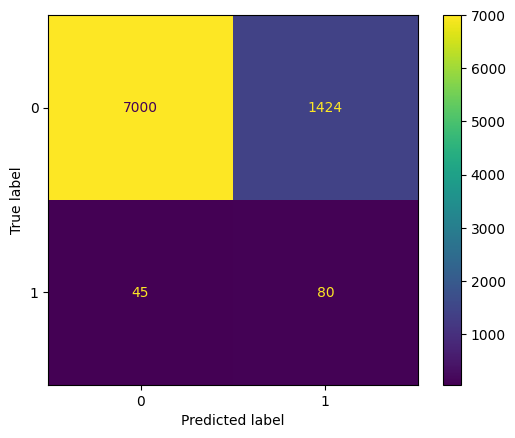

In [8]:
# Train the best model on full training data (train + val)
best_model = train_and_tune_model(
    log_model, log_param_grid, 
    pd.concat([X_train, X_val]),  # Combine train and val
    pd.concat([y_train, y_val]), 
    X_val,
    y_val,
    model_name="Final Model"
)

# Evaluation on test set (which was NEVER used before)
y_test_pred = best_model.predict(X_test)
y_test_proba = best_model.predict_proba(X_test)[:, 1]  # For metrics like AUC-ROC

# Generate report
from sklearn.metrics import classification_report, roc_auc_score

print("FINAL RESULTS ON TEST SET")
print(classification_report(y_test, y_test_pred))
print(f"AUC-ROC: {roc_auc_score(y_test, y_test_proba):.4f}")


# Confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)
plt.show()

Training final model (LogisticRegression with C=0.1) on combined training and validation data...
Training completed.

=== EVALUATION ON TEST SET ===

CLASSIFICATION REPORT (Test Set):
              precision    recall  f1-score   support

           0       0.99      0.83      0.91      8424
           1       0.05      0.64      0.10       125

    accuracy                           0.83      8549
   macro avg       0.52      0.74      0.50      8549
weighted avg       0.98      0.83      0.89      8549

AUC-ROC SCORE (Test Set): 0.7924

Confusion Matrix (Test Set):


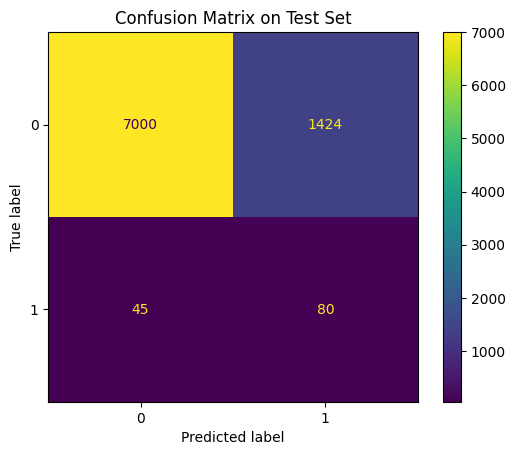

Balanced Accuracy (Test Set): 0.7355


In [9]:
# Best value for C set to 0.1
final_C_value = 0.1

# Initialize logistic regression model with best C parameter
# Note: class_weight='balanced' and random_state=42 are very important for imbalanced data and reproducibility
final_log_model = LogisticRegression(
    max_iter=5000,
    class_weight='balanced',
    random_state=42,
    C=final_C_value  # Using best C = 0.1
)

final_pipeline = ImbPipeline(steps=[
    ('preprocessing', preprocessor),  # Your defined preprocessor
    ('smote', SMOTENC(categorical_features=categorical_features_indices, random_state=42)),  # Make sure categorical_features_indices is correct
    ('classifier', final_log_model)
])

# === Combining training and validation data for final training ===
# This is a key step: we combine X_train and X_val to train the final model on more data.
X_combined_train_val = pd.concat([X_train, X_val], ignore_index=True)
y_combined_train_val = pd.concat([y_train, y_val], ignore_index=True)

print(f"Training final model ({final_log_model.__class__.__name__} with C={final_C_value}) on combined training and validation data...")
final_pipeline.fit(X_combined_train_val, y_combined_train_val)
print("Training completed.")

# === Evaluation on the test set (NEVER used before) ===
print("\n=== EVALUATION ON TEST SET ===")
y_test_pred = final_pipeline.predict(X_test)
y_test_proba = final_pipeline.predict_proba(X_test)[:, 1]  # Probabilities for the positive class (1)

# Generate classification report
print("\nCLASSIFICATION REPORT (Test Set):")
print(classification_report(y_test, y_test_pred))

# Calculate and display AUC-ROC score
auc_score_test = roc_auc_score(y_test, y_test_proba)
print(f"AUC-ROC SCORE (Test Set): {auc_score_test:.4f}")

# Confusion matrix
print("\nConfusion Matrix (Test Set):")
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)
plt.title("Confusion Matrix on Test Set")
plt.show()

# Optional: Balanced accuracy on the test set
from sklearn.metrics import balanced_accuracy_score
balanced_acc_test = balanced_accuracy_score(y_test, y_test_pred)
print(f"Balanced Accuracy (Test Set): {balanced_acc_test:.4f}")


## PREDICTIONS

#### Predictions for all observations in test dataset - as there wasn't observation id in the test dataset I decided to produce full csv

In [11]:
# Load test data
df_test = pd.read_csv(f"{raw_input_data_path}/insurance_test.csv")

# Preserve identifier (if exists, e.g., claim_id or other unique ID)
# If no identifier exists, keep the index as reference
df_test_reset = df_test.reset_index(drop=True)

# Apply data transformations - same preprocessing as training set 
# (preprocessor was already fitted during training)
X_test = df_test[log_cols + target_cols].copy()

# Generate probabilistic predictions and class predictions
claim_proba = best_log.predict_proba(X_test)[:, 1]  # Probability of positive class
claim_pred = best_log.predict(X_test)  # Binary class predictions

# Combine predictions with original test data
df_test_with_preds = df_test_reset.copy()
df_test_with_preds['claim_proba'] = claim_proba  # Add probability predictions
df_test_with_preds['claim_pred'] = claim_pred    # Add class predictions

# Export results and preview
df_test_with_preds.to_csv(f"insurance_test_with_predictions.csv", index=False)
print("Test data with predictions preview:")
df_test_with_preds.head()

Test data with predictions preview:


,reward,person_gender,entity_type,channel,support_interactions,agent_id,customer_score,entity_a,person_age,location,revenue,product_id,trip_length,claim_proba,claim_pred
0,84.316320,9b2d5b46,type_a,web,2,agt_0001,0.009257,96d6c6df,31,ireland,-141.716239,DriveSafe Rental Addon,73,0.149040,0
1,45.884363,9b2d5b46,type_a,web,0,agt_0001,0.108049,96d6c6df,29,australia,82.225268,DriveSafe Rental Addon,25,0.586419,1
2,0.000000,9b2d5b46,type_a,web,2,agt_0004,0.108814,50b3e71e,26,indonesia,10.247118,TripGuard Cancel,6,0.186742,0
3,29.363482,f67ab10a,type_b,web,1,agt_0002,0.215505,7b5dbb09,32,france,83.483247,TravelShield Value,73,0.589238,1
4,12.440951,08f27188,type_b,web,0,agt_0005,0.194798,99ede4e4,26,singapore,46.679372,TravelShield Plus,32,0.786732,1
